# Set Up

This script is only intended for testing purpose.

In [ ]:
!pip install timm==0.4.5 transformers==4.5.1 packaging==21.3 # for MDETR

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 65.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.4 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=2974d07050d810ff953c2b11cd58c5c05cd0b1ed1166aef46bf74fba4d94e1be
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
  Attempting uninstall: packaging
    Found existing installation: packaging 23.0
    Uninstalling packaging-23.0:
      Successfully uninstalled packaging-23.0


In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
# !unzip "/content/gdrive/Shareddrives/cis700/images/GQA_subset/testdev_images.zip" -d "/content"
# !cp "/content/gdrive/Shareddrives/cis700/questions/relational_testdev_100.json" "/content"
!unzip "/content/gdrive/MyDrive/cis700/dataset/testdev_images.zip" -d "/content"
!cp "/content/gdrive/MyDrive/cis700/dataset/relational_testdev_100.json" "/content"
!pip install transformers --upgrade
!pip install openai
!pip install langchain
!pip install accelerate

In [1]:
import openai
import json
import os
import torch
from PIL import Image
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain, ConversationChain
from langchain.memory import ConversationBufferMemory

# os.environ["OPENAI_API_KEY"] = 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_FOLDER = r"/content/testdev_images"
Q_PATH = r"/content/relational_testdev_100.json"

# Preparation

In [ ]:
with open(Q_PATH,'r') as f:
    js = json.load(f)

# test_q = qs[10]
sample = js['202158945']

## Read Image

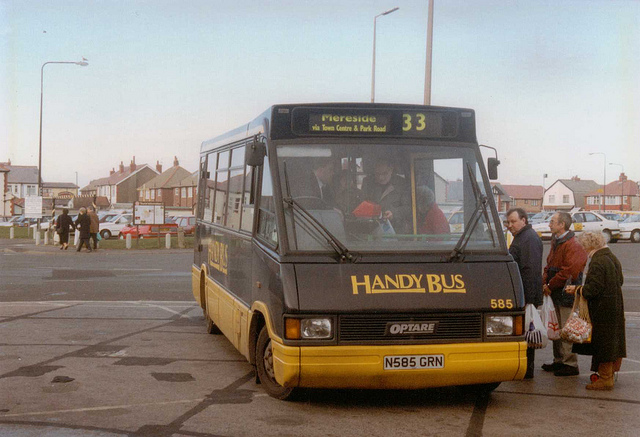

In [ ]:
image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))
display(image)

## Image Captioning

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
model.to(DEVICE);

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Caption

In [ ]:
inputs = processor(image, return_tensors="pt").to(DEVICE, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

In [ ]:
caption

'a bus with people on it'

List of objects

In [ ]:
caption_prompt = "a list of all objects in the image: "
inputs = processor(image, text=caption_prompt, return_tensors="pt").to(DEVICE, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
l_objs = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

In [ ]:
l_objs

'bus, people, cars, buildings, sky, etc'

In [ ]:
samples = [js[key] for key in list(js.keys())]
print(len(samples))

100


## MDETR

In [ ]:
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

torch.set_grad_enabled(False);

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

In [ ]:
model_qa = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5_gqa', pretrained=True, return_postprocessor=False)
model_qa = model_qa.cuda()
model_qa.eval();

Using cache found in /root/.cache/torch/hub/ashkamath_mdetr_main
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://zenodo.org/record/4721981/files/gqa_EB5_checkpoint.pth" to /root/.cache/torch/hub/checkpoints/gqa_EB5_checkpoint.pth
  3%|▎         | 84.9M/2.54G [04:34<2:15:13, 325kB/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/hub.py:558 in load                                  │
│                                                                                                  │
│   555 │   │   repo_or_dir = _get_cache_or_reload(repo_or_dir, force_reload, trust_repo, "load"   │
│   556 │   │   │   │   │   │   │   │   │   │      verbose=verbose, skip_validation=skip_validat   │
│   557 │                                                                                          │
│ ❱ 558 │   model = _load_local(repo_or_dir, model, *args, **kwargs)                               │
│   559 │   return model                                                                           │
│   560                                                                                            │
│   561                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/hub.py:587 in _load_local                           │
│                                                                                                  │
│   584 │   │   hub_module = _import_module(MODULE_HUBCONF, hubconf_path)                          │
│   585 │   │                                                                                      │
│   586 │   │   entry = _load_entry_from_hubconf(hub_module, model)                                │
│ ❱ 587 │   │   model = entry(*args, **kwargs)                                                     │
│   588 │                                                                                          │
│   589 │   return model                                                                           │
│   590                                                                                            │
│                                                                                                  │
│ /root/.cache/torch/hub/ashkamath_mdetr_main/hubconf.py:179 in mdetr_efficientnetB5_gqa           │
│                                                                                                  │
│   176 │                                                                                          │
│   177 │   model = _make_detr("timm_tf_efficientnet_b5_ns", qa_dataset="gqa", contrastive_align   │
│   178 │   if pretrained:                                                                         │
│ ❱ 179 │   │   checkpoint = torch.hub.load_state_dict_from_url(                                   │
│   180 │   │   │   url="https://zenodo.org/record/4721981/files/gqa_EB5_checkpoint.pth", map_lo   │
│   181 │   │   )                                                                                  │
│   182 │   │   model.load_state_dict(checkpoint["model"])                                         │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/torch/hub.py:746 in load_state_dict_from_url              │
│                                                                                                  │
│   743 │   │   if check_hash:                                                                     │
│   744 │   │   │   r = HASH_REGEX.search(filename)  # r is Optional[Match[str]]                   │
│   745 │   │   │   hash_prefix = r.group(1) if r else None                                        │
│ ❱ 746 │   │   download_url_to_file(url, cached_file, hash_prefix, progress=progress)             │
│   747 │                                                    

In [ ]:
import json
answer2id_by_type = json.load(requests.get("https://nyu.box.com/shared/static/j4rnpo8ixn6v0iznno2pim6ffj3jyaj8.json", stream=True).raw)
id2answerbytype = {}                                                       
for ans_type in answer2id_by_type.keys():                        
    curr_reversed_dict = {v: k for k, v in answer2id_by_type[ans_type].items()}
    id2answerbytype[ans_type] = curr_reversed_dict                             

In [ ]:
def plot_inference_qa(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).cuda()

  # propagate through the model
  memory_cache = model_qa(img, [caption], encode_and_save=True)
  outputs = model_qa(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        if span == None:
          continue
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  # plot_results(im, probas[keep], bboxes_scaled, labels)

  # Classify the question type
  type_conf, type_pred = outputs["pred_answer_type"].softmax(-1).max(-1)
  ans_type = type_pred.item()
  types = ["obj", "attr", "rel", "global", "cat"]

  ans_conf, ans = outputs[f"pred_answer_{types[ans_type]}"][0].softmax(-1).max(-1)
  answer = id2answerbytype[f"answer_{types[ans_type]}"][ans.item()]
  # print(f"Predicted answer: {answer}\t confidence={round(100 * type_conf.item() * ans_conf.item(), 2)}")
  return answer

In [ ]:
plot_inference_qa(image, "Is the large vehicle to the left of the people that are standing?")

# Chain-of-Thought Reasoning (batch ver.)

Config

In [ ]:
samples = [js[key] for key in list(js.keys())]
print(len(samples))

In [ ]:
question_type = 2 # TODO: hard coded for now

def vqa_inference(question_gpt, question_type):
  generated_text = ''
  if question_type == 1:
    question_prompt = f"Question: {question_gpt} Answer:"
    inputs = processor(image, text=question_prompt, return_tensors="pt").to(DEVICE, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  elif question_type == 2:
    question_prompt = question_gpt
    generated_text = plot_inference_qa(image, question_prompt)
  return generated_text

In [ ]:
template_prefix = f"""
Here are some information of an image:
Caption: {caption}
List of objects: {l_objs}
Your task is to answer the question: {sample['question']}
"""
template = template_prefix+"""
{history}
{input}
"""
llm = ChatOpenAI(model_name='gpt-3.5-turbo')
prompt = PromptTemplate(input_variables=['history', 'input'], template=template)
# chain = ConversationChain(llm=llm, prompt=prompt, verbose=True, memory=ConversationBufferMemory(human_prefix="", ai_prefix=""))
caption_prompt = "a list of all objects in the image: "
can_prompt = "Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons."
clarify_prompt = "List your clarifying questions:"
final_prompt = f"Answer this question with yes or no: {sample['question']}"

In [ ]:
def is_relational_question(chatgpt_question):
  response = openai.Completion.create(
  model="text-davinci-003",
  prompt="Q: Are there any other details or clues in the image that could indicate the position of the open drapes?\nA: Not relational question\n\nQ: Is there any additional information about the layout or orientation of the bedroom that could help determine the position of the drapes?\nA: Not relational\n\nQ: What is the distance between the girl and the kite?\nA: Relational\n\nQ: Are the drapes visible in this image or is their position only mentioned in the caption?\nA: Not relational question\n\nQ: How high in the sky is the kite flying\nA: Relational question\n\nQ: Is there any other object in the picture that is higher than the girl's kite?\nA: Relational question\n\nQ: "\
   + chatgpt_question + "\nA:",
  temperature=0,
  max_tokens=100,
  top_p=1,
  frequency_penalty=0.0,
  presence_penalty=0.0,
  stop=["\n"]
  )
  in_context_answer = response.choices[0].text[1:]
  return in_context_answer

In [ ]:
chatgpt_question = "Is there any information about the direction of the open drapes?"
in_context_answer = is_relational_question(chatgpt_question)

In [ ]:
in_context_answer

In [ ]:
in_context_answer[:4] == "Not"

In [ ]:

corrects = 0
max_iter = 3
num_sample = 0
for sample in samples:
    num_sample += 1
    print("iteration: ", num_sample)
    # sample = samples[4]
    # Step 0: Preparation
    image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))

    # Step 1: Image Captioning
    inputs = processor(image, return_tensors="pt").to(DEVICE, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    # Step 2: Object Detection
    inputs = processor(image, text=caption_prompt, return_tensors="pt").to(DEVICE, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=20)
    l_objs = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()


    template_prefix = f"""
    Here are some information of an image:
    Caption: {caption}
    List of objects: {l_objs}
    Your task is to answer the question: {sample['question']}
    """
    template = template_prefix+"""
    {history}
    {input}
    """
    llm = ChatOpenAI(model_name='gpt-3.5-turbo')
    prompt = PromptTemplate(input_variables=['history', 'input'], template=template)
    # chain = ConversationChain(llm=llm, prompt=prompt, verbose=True, memory=ConversationBufferMemory(human_prefix="", ai_prefix=""))
    caption_prompt = "a list of all objects in the image: "
    can_prompt = "Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons."
    clarify_prompt = "List your clarifying questions:"
    final_prompt = f"Answer this question with yes or no: {sample['question']}"


    chain = ConversationChain(llm=llm, prompt=prompt, verbose=True, memory=ConversationBufferMemory(human_prefix="", ai_prefix=""))
    default_prompt = can_prompt

    # Step 3: Chain-of-Thought Reasoning
    iter = 0
    while iter < max_iter:
        iter += 1   
        # Step 3.1: Confirm whether ChatGPT can already answer the question
        can_answer = chain.predict(input=default_prompt).replace(":","").strip()


        # Step 3.2.1: If no, ChatGPT asks clarifying questions, and BLIP-2 answers them.
        if can_answer[:2] == 'Ye':
          break
        else:
          clarifying_questions = chain.predict(input=clarify_prompt).strip().split('\n')
          if clarifying_questions[0][0].lower() == 'n':
              print("There is no clarifying question to ask.")
              break
          else:
              answers = []
              for cq in clarifying_questions:
                question_type = 1
                in_context_answer = is_relational_question(cq[2:].strip())
                if in_context_answer[:10] == "Relational":
                  question_type = 2
                generated_text = vqa_inference(cq[2:].strip(), question_type)
                answers.append(generated_text)
              default_prompt = "\n".join([clarifying_questions[i] + " " + answers[i] + '.' for i in range(len(answers))])+'\n'+can_prompt
              chain.memory.chat_memory.messages.pop(-1)   # to avoid redundancy of clarifying questions appear twice



        # # Step 3.2.1: If no, ChatGPT asks clarifying questions, and BLIP-2 answers them.
        # if can_answer[:2] == 'No':
        #     clarifying_questions = chain.predict(input=clarify_prompt).strip().split('\n')
        #     if clarifying_questions[0][0].lower() == 'n':
        #         print("There is no clarifying question to ask.")
        #         break
        #     else:
        #         answers = []
        #         for cq in clarifying_questions:
        #           generated_text = vqa_inference(cq[2:].strip(), 2)
        #           answers.append(generated_text)
        #         default_prompt = "\n".join([clarifying_questions[i] + " " + answers[i] + '.' for i in range(len(answers))])+'\n'+can_prompt
        #         chain.memory.chat_memory.messages.pop(-1)   # to avoid redundancy of clarifying questions appear twice

        # # Step 3.2.2: If yes, break the chain
        # elif can_answer[:2] == 'Ye':
        #     break

        # # Step 3.2.3: Raise error if ChatGPT did not follow our command.
        # else:
        #     print(can_answer)
        #     raise ValueError("ChatGPT did not answer with Yes or No!")
    
    # Step 4: Answer Inference
    answer = chain.predict(input=final_prompt).replace(":","").strip()
    print('predicted: ', answer)
    print('ground truth: ', sample["answer"])
    # check accuracy
    # if answer.split()[0].replace('.','').lower() == sample["answer"].lower():
    
    if sample["answer"].lower() in answer.lower():
        print(True)
        corrects += 1
    else:
        print(False) 
    # break      
  
acc = corrects/len(samples)
print(acc)

iteration:  1


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a motorcycle parked on the side of the road
    List of objects: motorcycle, car, building, street, sidewalk, grass, pavement, sidewalk, street, sidewalk,
    Your task is to answer the question: Is the green tree behind the building?
    
    
    Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
    

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a motorcycle parked on the side of the road
    List of objects: motorcycle, car, building, street, sidewalk, grass, pavement, sidewalk, street, sidewalk,
    Your task is to answer the question: Is the green tree behind the building?
    
    : Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
: As an AI language model, I don't have the ability to 


> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a small bedroom with a bed and a couch
    List of objects: bed, chair, mirror, lamp, table, couch, and floor
    Your task is to answer the question: What is around the open window?
    
    : Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
: No, I cannot answer the question as there is no mention of an open window in the given information.
: List your clarifying questions:
    1. Is there actually an open window in the image or is this a hypothetical question? No.
2. If there is an open window in the image, can you provide more details about its location and size? Yes, the window is in the bedroom.
3. Are there any other objects near the window that could provide clues about what is around it? Yes, there is a small table near the window.
4. Is there any other context or information available that could help an


> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a little boy riding a bike next to a stop sign
    List of objects: stop sign, children, sidewalk, trees, water
    Your task is to answer the question: Do you see a bicycle to the left of the small baby?
    
    : Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
: No. The caption only mentions a little boy riding a bike, but there is no mention of a small baby in the provided information. Additionally, the list of objects does not include a bicycle or a small baby.
    List your clarifying questions:
    

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a little boy riding a bike next to a stop sign
    List of objects: stop sign, children, sidewalk, trees, water
    Your task is to answer the question: Do you see a 

  "error": {
    "message": "The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 55be78ad97f86b7613022b5291bb48b5 in your message.)",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 55be78ad97f86b7613022b5291bb48b5 in your message.)', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 18 Apr 2023 18:24:46 GMT', 'Content-Type': 'application/json', 'Content-Length': '366', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-3.5-turbo-0301', 'openai-organization': 'user-ak7y4xi1m2ksspywua3vfzmd', 'openai-processing-ms': '301


> Finished chain.
predicted:  No.
ground truth:  tree
False
iteration:  45


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a kitchen with a sink, a table, and a window
    List of objects: a table, a window, a sink, a refrigerator, a stove, a microwave, a dish
    Your task is to answer the question: Behind what kind of appliance is the countertop?
    
    
    Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
    

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a kitchen with a sink, a table, and a window
    List of objects: a table, a window, a sink, a refrigerator, a stove, a microwave, a dish
    Your task is to answer the question: Behind what kind of appliance is the countertop?
    
    : Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
: Yes. 


> Finished chain.
predicted:  No.
ground truth:  yes
False
iteration:  47


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a man and a woman with a baby sitting at a table
    List of objects: a man, a woman, a child, a cake, a knife, a fork, a plate
    Your task is to answer the question: What is the name of the food that has the same color as the dessert near the plates?
    
    
    Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
    

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a man and a woman with a baby sitting at a table
    List of objects: a man, a woman, a child, a cake, a knife, a fork, a plate
    Your task is to answer the question: What is the name of the food that has the same color as the dessert near the plates?
    
    : Can you answer the question? Reply '

  "error": {
    "message": "The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2586e69ad30d15eaf0ea57e331ee1513 in your message.)",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 2586e69ad30d15eaf0ea57e331ee1513 in your message.)', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 18 Apr 2023 18:27:45 GMT', 'Content-Type': 'application/json', 'Content-Length': '366', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-3.5-turbo-0301', 'openai-organization': 'user-ak7y4xi1m2ksspywua3vfzmd', 'openai-processing-ms': '300


> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a kitchen with a bar and a couch
    List of objects: a kitchen, a living room, a dining room, a bar, a couch, a table,
    Your task is to answer the question: Which kind of furniture is the staircase behind of?
    
    : Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
: No, I cannot answer the question because the information provided does not mention anything about a staircase.
: List your clarifying questions:
    1. Is there a staircase in the image?  Yes.
2. If yes, where is it located in relation to the other objects listed?  office.
3. What does the staircase look like?  It's a staircase.
4. Is it possible to provide more information or a different image that includes the staircase? No.
Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
    

> Finished chain.


> Entering n

  "error": {
    "message": "The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID e9cb38ade3fd377c691e0fb0d7b6a17e in your message.)",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID e9cb38ade3fd377c691e0fb0d7b6a17e in your message.)', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 18 Apr 2023 18:28:45 GMT', 'Content-Type': 'application/json', 'Content-Length': '366', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-3.5-turbo-0301', 'openai-organization': 'user-ak7y4xi1m2ksspywua3vfzmd', 'openai-processing-ms': '300


> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a kitchen with a bar and a couch
    List of objects: a kitchen, a living room, a dining room, a bar, a couch, a table,
    Your task is to answer the question: Is the steep staircase behind the chairs next to the cupboard?
    
    : Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
: As an AI language model, I cannot see the image you are referring to. Therefore, I cannot determine whether the steep staircase is behind the chairs next to the cupboard. Please provide more information or context to help me better understand the situation.
: List your clarifying questions:
    1. Can you provide a description or location of the chairs and cupboard in the image? Yes.
2. Is the staircase visible in the image or is it only mentioned in the caption? The staircase is visible in the image.
3. Is there any other furniture

  "error": {
    "message": "The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 7bd273b05c4c5ed55ca347db9d557f6d in your message.)",
    "type": "server_error",
    "param": null,
    "code": null
  }
}
 500 {'error': {'message': 'The server had an error while processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 7bd273b05c4c5ed55ca347db9d557f6d in your message.)', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Tue, 18 Apr 2023 18:33:13 GMT', 'Content-Type': 'application/json', 'Content-Length': '366', 'Connection': 'keep-alive', 'access-control-allow-origin': '*', 'openai-model': 'gpt-3.5-turbo-0301', 'openai-organization': 'user-ak7y4xi1m2ksspywua3vfzmd', 'openai-processing-ms': '300


> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a woman sitting at a table with a pizza and a salad
    List of objects: pizza, salad, and drinks
    Your task is to answer the question: Are there pizzas on the table?
    
    : Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
: Yes, there are pizzas on the table. The caption explicitly states that there is a pizza on the table.
    Answer this question with yes or no: Are there pizzas on the table?
    

> Finished chain.
predicted:  Yes.
ground truth:  yes
True
iteration:  85


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a woman sitting at a table with a pizza and a salad
    List of objects: pizza, salad, and drinks
    Your task is to answer the question: What is that pizza on, a bed or a table?
    
    
    Can you answer the


> Finished chain.
predicted:  Yes.
ground truth:  table
False
iteration:  88


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a woman sitting at a table with a pizza and a salad
    List of objects: pizza, salad, and drinks
    Your task is to answer the question: What is the pizza on?
    
    
    Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
    

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:

    Here are some information of an image:
    Caption: a woman sitting at a table with a pizza and a salad
    List of objects: pizza, salad, and drinks
    Your task is to answer the question: What is the pizza on?
    
    : Can you answer the question? Reply 'Yes' or 'No' first, then give your reasons.
: Yes. The image description mentions a woman sitting at a table with a pizza and a salad, but it does not provide any information about wh

In [ ]:
acc = corrects/len(samples)
print(acc)

0.34


In [ ]:
# use only type 2: 0.14
# two types: 0.24

# MDETR baseline

In [ ]:
num_sample = 0
corrects = 0

for sample in samples:
  num_sample += 1
  print("iteration: ", num_sample)
  image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))
  question = sample['question']
  generated_text = plot_inference_qa(image, question)

  print('predicted: ', generated_text)
  print('ground truth: ', sample["answer"])

  # if generated_text.lower() == sample["answer"].lower():
  if sample["answer"].lower() in generated_text.lower():
    print(True)
    corrects += 1
  else:
    print(False)

acc = corrects/len(samples)
print(acc)

iteration:  1
predicted:  yes
ground truth:  no
False
iteration:  2
predicted:  no
ground truth:  yes
False
iteration:  3
predicted:  yes
ground truth:  yes
True
iteration:  4
predicted:  yes
ground truth:  yes
True
iteration:  5
predicted:  right
ground truth:  right
True
iteration:  6
predicted:  curtains
ground truth:  drapes
False
iteration:  7
predicted:  curtains
ground truth:  drapes
False
iteration:  8
predicted:  window
ground truth:  window
True
iteration:  9
predicted:  dishwasher
ground truth:  refrigerator
False
iteration:  10
predicted:  yes
ground truth:  no
False
iteration:  11
predicted:  yes
ground truth:  yes
True
iteration:  12
predicted:  table
ground truth:  table
True
iteration:  13
predicted:  wall
ground truth:  wall
True
iteration:  14
predicted:  yes
ground truth:  yes
True
iteration:  15
predicted:  truck
ground truth:  van
False
iteration:  16
predicted:  yes
ground truth:  yes
True
iteration:  17
predicted:  no
ground truth:  yes
False
iteration:  18
predi

In [ ]:
# 0.77

# MDETR ChatGPT

In [ ]:
num_sample = 0
corrects = 0


for sample in samples:
  num_sample += 1
  print("iteration: ", num_sample)
  image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))
  question = sample['question']

  inputs = processor(image, return_tensors="pt").to(DEVICE, torch.float16)
  generated_ids = model.generate(**inputs, max_new_tokens=20)
  caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

  title_to_gpt = "Here are some information of an image:\n"
  caption_to_gpt = caption
  task_to_gpt = "\nYour task is to answer question: "
  question_to_gpt = question
  format_to_gpt = "\nList five relational questions to help you answer the given question.\nRelational question examples: 'What is on the tree to the left of the person?', 'On which side of the photo is the man?', 'What animal is in the box?', 'Is there any ice?', 'What kind of device is the woman holding, a remote control or a cell phone?':"
  prompt_to_gpt = title_to_gpt + caption_to_gpt + task_to_gpt + question_to_gpt + format_to_gpt

  completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "user", "content": prompt_to_gpt}
    ]
  )

  clarifying_questions = completion.choices[0].message.content
  clarifying_questions = clarifying_questions.split('\n')
  complete_clarifying_questions = ""

  for i, q in enumerate(clarifying_questions):
    q = q.split(".")[1][1:]
    clarifying_answer = plot_inference_qa(image, q)
    clarifying_questions[i] += ": " + clarifying_answer
    complete_clarifying_questions += clarifying_questions[i] + "\n"

  # print(complete_clarifying_questions)

  information_to_gpt = "\nYou have the following information: \n"
  prompt_to_gpt = title_to_gpt + caption_to_gpt + task_to_gpt + question_to_gpt + information_to_gpt + complete_clarifying_questions + '\nPlease answer with one word.'
  print(prompt_to_gpt)

  completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt_to_gpt}
  ]
  )

  print('predicted: ', completion.choices[0].message.content)
  print('ground truth: ', sample["answer"])

  if sample["answer"].lower() in generated_text.lower():
    print(True)
    corrects += 1
  else:
    print(False)
  # break

acc = corrects/len(samples)
print(acc)


iteration:  1


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:22                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/openai/api_resources/chat_completion.py:25 in create      │
│                                                                                                  │
│   22 │   │                                                                                       │
│   23 │   │   while True:                                                                         │
│   24 │   │   │   try:                                                                            │
│ ❱ 25 │   │   │   │   return super().create(*args, **kwargs)                                      │
│   26 │   │   │   except TryAgain as e:                                                           │
│   27 │   │   │   │   if timeout is not None and time.time() > start + timeout:                   │
│   28 │   │   │   │   │   raise                                                                   │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/openai/api_resources/abstract/engine_api_resource.py:153  │
│ in create                                                                                        │
│                                                                                                  │
│   150 │   │   │   api_key, api_base, api_type, api_version, organization, **params               │
│   151 │   │   )                                                                                  │
│   152 │   │                                                                                      │
│ ❱ 153 │   │   response, _, api_key = requestor.request(                                          │
│   154 │   │   │   "post",                                                                        │
│   155 │   │   │   url,                                                                           │
│   156 │   │   │   params=params,                                                                 │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/openai/api_requestor.py:216 in request                    │
│                                                                                                  │
│   213 │   │   request_id: Optional[str] = None,                                                  │
│   214 │   │   request_timeout: Optional[Union[float, Tuple[float, float]]] = None,               │
│   215 │   ) -> Tuple[Union[OpenAIResponse, Iterator[OpenAIResponse]], bool, str]:                │
│ ❱ 216 │   │   result = self.request_raw(                                                         │
│   217 │   │   │   method.lower(),                                                                │
│   218 │   │   │   url,                                                                           │
│   219 │   │   │   params=params,                                                                 │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/openai/api_requestor.py:516 in request_raw                │
│                                                                                                  │
│   513 │   │   if not hasattr(_thread_context, "session"):                                        │
│   514 │   │   │   _thread_context.session = _make_session()                                      │
│   515 │   │   try:                                                                               │
│ ❱ 516 │   │   │   result = _thread_context.session.request(

In [ ]:
# 0.38

# MDETR ChatGPT with MDETR Answer

In [ ]:
num_sample = 0
corrects = 0


for sample in samples:
  num_sample += 1
  print("iteration: ", num_sample)
  image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))
  question = sample['question']

  inputs = processor(image, return_tensors="pt").to(DEVICE, torch.float16)
  generated_ids = model.generate(**inputs, max_new_tokens=20)
  caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

  title_to_gpt = "Here are some information of an image:\n"
  caption_to_gpt = caption
  task_to_gpt = "\nYour task is to answer question: "
  question_to_gpt = question
  format_to_gpt = "\nList five relational questions to help you answer the given question.\nRelational question examples: 'What is on the tree to the left of the person?', 'On which side of the photo is the man?', 'What animal is in the box?', 'Is there any ice?', 'What kind of device is the woman holding, a remote control or a cell phone?':"
  prompt_to_gpt = title_to_gpt + caption_to_gpt + task_to_gpt + question_to_gpt + format_to_gpt

  completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "user", "content": prompt_to_gpt}
    ]
  )

  clarifying_questions = completion.choices[0].message.content
  clarifying_questions = clarifying_questions.split('\n')
  complete_clarifying_questions = ""

  for i, q in enumerate(clarifying_questions):
    q = q.split(".")[1][1:]
    clarifying_answer = plot_inference_qa(image, q)
    clarifying_questions[i] += ": " + clarifying_answer
    complete_clarifying_questions += clarifying_questions[i] + "\n"

  # print(complete_clarifying_questions)
  generated_text = plot_inference_qa(image, question)
  answer_from_vqa = "\nYou are given the answer to the question: " + generated_text +".\nBut you are not sure if the answer is correct and you may want to adjust the answer based on additional information above."\
   + "\nThe addtional information may also be wrong, please evaluate them all together and give a final answer. If you are not sure about the final answer, just give the final answer as the given answer."
  information_to_gpt = "\nYou have the following information: \n"
  prompt_to_gpt = title_to_gpt + caption_to_gpt +\
   information_to_gpt + \
   complete_clarifying_questions + task_to_gpt + question_to_gpt + answer_from_vqa + '\nPlease answer with one word.'
  print(prompt_to_gpt)

  completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt_to_gpt}
  ]
  )

  print('predicted: ', completion.choices[0].message.content)
  print('ground truth: ', sample["answer"])

  if sample["answer"].lower() in completion.choices[0].message.content.lower():
    print(True)
    corrects += 1
  else:
    print(False)
  # break

acc = corrects/len(samples)
print(acc)


In [ ]:
# 0.73

# MDETR ChatGPT; With MDETR Answer; No Caption

In [ ]:
num_sample = 0
corrects = 0


for sample in samples:
  num_sample += 1
  print("iteration: ", num_sample)
  image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))
  question = sample['question']

  inputs = processor(image, return_tensors="pt").to(DEVICE, torch.float16)
  generated_ids = model.generate(**inputs, max_new_tokens=20)
  caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

  title_to_gpt = "Here are some information of an image:\n"
  caption_to_gpt = caption
  task_to_gpt = "Your task is to answer question: "
  question_to_gpt = question
  format_to_gpt = "\nList five relational questions to help you answer the given question.\nRelational question examples: 'What is on the tree to the left of the person?', 'On which side of the photo is the man?', 'What animal is in the box?', 'Is there any ice?', 'What kind of device is the woman holding, a remote control or a cell phone?':"
  prompt_to_gpt =  task_to_gpt + question_to_gpt + format_to_gpt

  completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "user", "content": prompt_to_gpt}
    ]
  )

  clarifying_questions = completion.choices[0].message.content
  clarifying_questions = clarifying_questions.split('\n')
  complete_clarifying_questions = ""

  for i, q in enumerate(clarifying_questions):
    q = q.split(".")[1][1:]
    clarifying_answer = plot_inference_qa(image, q)
    clarifying_questions[i] += ": " + clarifying_answer
    complete_clarifying_questions += clarifying_questions[i] + "\n"

  # print(complete_clarifying_questions)
  generated_text = plot_inference_qa(image, question)
  answer_from_vqa = "\nYou are given the answer to the question: " + generated_text +".\nBut you are not sure if the answer is correct and you may want to adjust the answer based on additional information above."\
   + "\nThe addtional information may also be wrong, please evaluate them all together and give a final answer. If you are not sure about the final answer, just give the final answer as the given answer."
  information_to_gpt = "\nYou have the following information: \n"
  # prompt_to_gpt = task_to_gpt + question_to_gpt + answer_from_vqa + information_to_gpt + \
  #  complete_clarifying_questions + '\nPlease answer with one word.'
  prompt_to_gpt = information_to_gpt + \
   complete_clarifying_questions + task_to_gpt + question_to_gpt + answer_from_vqa + '\nPlease answer with one word.'
  print(prompt_to_gpt)

  completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt_to_gpt}
  ]
  )

  print('predicted: ', completion.choices[0].message.content)
  print('ground truth: ', sample["answer"])

  if sample["answer"].lower() in completion.choices[0].message.content.lower():
    print(True)
    corrects += 1
  else:
    print(False)
  # break

acc = corrects/len(samples)
print(acc)


In [ ]:
# 0.67

# BLIP2 baseline

In [ ]:
def blip2_answer(image, question):
  question_prompt = f"Question: {question} Answer:"
  inputs = processor(image, text=question_prompt, return_tensors="pt").to(DEVICE, torch.float16)
  generated_ids = model.generate(**inputs, max_new_tokens=20)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  
  return generated_text

In [ ]:
num_sample = 0
corrects = 0

for sample in samples:
  num_sample += 1
  print("iteration: ", num_sample)
  image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))
  question = sample['question']
  generated_text = blip2_answer(image, question)

  print('predicted: ', generated_text)
  print('ground truth: ', sample["answer"])

  # if generated_text.lower() == sample["answer"].lower():
  if sample["answer"].lower() in generated_text.lower():
    print(True)
    corrects += 1
  else:
    print(False)

acc = corrects/len(samples)
print(acc)

iteration:  1
predicted:  Yes
ground truth:  no
False
iteration:  2
predicted:  Yes
ground truth:  yes
True
iteration:  3
predicted:  Yes
ground truth:  yes
True
iteration:  4
predicted:  Yes
ground truth:  yes
True
iteration:  5
predicted:  To the left
ground truth:  right
False
iteration:  6
predicted:  A bed
ground truth:  drapes
False
iteration:  7
predicted:  A bed
ground truth:  drapes
False
iteration:  8
predicted:  They are curtains
ground truth:  window
False
iteration:  9
predicted:  A refrigerator
ground truth:  refrigerator
True
iteration:  10
predicted:  Yes, it is a bus
ground truth:  no
False
iteration:  11
predicted:  Yes, it is a van
ground truth:  yes
True
iteration:  12
predicted:  A meal of turkey, mashed potatoes, carrots, and gravy
ground truth:  table
False
iteration:  13
predicted:  A black couch
ground truth:  wall
False
iteration:  14
predicted:  Yes
ground truth:  yes
True
iteration:  15
predicted:  A van
ground truth:  van
True
iteration:  16
predicted:  Yes

In [ ]:
# 0.53

# BLIP2 ChatGPT; With BLIP2 Answer

In [ ]:
num_sample = 0
corrects = 0


for sample in samples:
  num_sample += 1
  print("iteration: ", num_sample)
  image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))
  question = sample['question']

  inputs = processor(image, return_tensors="pt").to(DEVICE, torch.float16)
  generated_ids = model.generate(**inputs, max_new_tokens=20)
  caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

  title_to_gpt = "Here are some information of an image:\n"
  caption_to_gpt = caption
  task_to_gpt = "Your task is to answer question: "
  question_to_gpt = question
  format_to_gpt = "\nList five relational questions to help you answer the given question.\nRelational question examples: 'What is on the tree to the left of the person?', 'On which side of the photo is the man?', 'What animal is in the box?', 'Is there any ice?', 'What kind of device is the woman holding, a remote control or a cell phone?':"
  prompt_to_gpt =  task_to_gpt + question_to_gpt + format_to_gpt

  completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "user", "content": prompt_to_gpt}
    ]
  )

  clarifying_questions = completion.choices[0].message.content
  clarifying_questions = clarifying_questions.split('\n')
  complete_clarifying_questions = ""

  for i, q in enumerate(clarifying_questions):
    q = q.split(".")[1][1:]
    clarifying_answer = blip2_answer(image, q)
    clarifying_questions[i] += ": " + clarifying_answer
    complete_clarifying_questions += clarifying_questions[i] + "\n"

  # print(complete_clarifying_questions)
  generated_text = blip2_answer(image, question)
  answer_from_vqa = "\nYou are given the answer to the question: " + generated_text +".\nBut you are not sure if the answer is correct and you may want to adjust the answer based on additional information above."\
   + "\nThe addtional information may also be wrong, please evaluate them all together and give a final answer. If you are not sure about the final answer, just give the final answer as the given answer."
  information_to_gpt = "\nYou have the following information: \n"
  prompt_to_gpt = title_to_gpt + caption_to_gpt + information_to_gpt + \
   complete_clarifying_questions + task_to_gpt + question_to_gpt + answer_from_vqa + '\nPlease answer with one word.'
  print(prompt_to_gpt)

  completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt_to_gpt}
  ]
  )

  print('predicted: ', completion.choices[0].message.content)
  print('ground truth: ', sample["answer"])

  if sample["answer"].lower() in completion.choices[0].message.content.lower():
    print(True)
    corrects += 1
  else:
    print(False)
  # break

acc = corrects/len(samples)
print(acc)


iteration:  1
Here are some information of an image:
a motorcycle parked on the side of the road
You have the following information: 
1. What is the position of the green tree with respect to the building?: The tree is in the shade
2. Is the green tree closer to the foreground or the background than the building?: The tree is closer to the foreground
3. Is the green tree visible in the same frame as the building?: Yes
4. Is there any obstruction between the building and the green tree?: No
5. Is the green tree taller or shorter than the building?: It's taller
Your task is to answer question: Is the green tree behind the building?
You are given the answer to the question: Yes.
But you are not sure if the answer is correct and you may want to adjust the answer based on additional information above.
The addtional information may also be wrong, please evaluate them all together and give a final answer. If you are not sure about the final answer, just give the final answer as the given answ

In [ ]:
# 0.56

# BLIP2 ChatGPT; With BLIP2 Answer; No Caption

In [ ]:
num_sample = 0
corrects = 0


for sample in samples:
  num_sample += 1
  print("iteration: ", num_sample)
  image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))
  question = sample['question']

  inputs = processor(image, return_tensors="pt").to(DEVICE, torch.float16)
  generated_ids = model.generate(**inputs, max_new_tokens=20)
  caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

  title_to_gpt = "Here are some information of an image:\n"
  caption_to_gpt = caption
  task_to_gpt = "Your task is to answer question: "
  question_to_gpt = question
  format_to_gpt = "\nList five relational questions to help you answer the given question.\nRelational question examples: 'What is on the tree to the left of the person?', 'On which side of the photo is the man?', 'What animal is in the box?', 'Is there any ice?', 'What kind of device is the woman holding, a remote control or a cell phone?':"
  prompt_to_gpt =  task_to_gpt + question_to_gpt + format_to_gpt

  completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "user", "content": prompt_to_gpt}
    ]
  )

  clarifying_questions = completion.choices[0].message.content
  clarifying_questions = clarifying_questions.split('\n')
  complete_clarifying_questions = ""

  for i, q in enumerate(clarifying_questions):
    if len(q.split(".")) > 1:
      q = q.split(".")[1][1:]
    else:
      continue
    clarifying_answer = blip2_answer(image, q)
    clarifying_questions[i] += ": " + clarifying_answer
    complete_clarifying_questions += clarifying_questions[i] + "\n"

  # print(complete_clarifying_questions)
  generated_text = blip2_answer(image, question)
  answer_from_vqa = "\nYou are given the answer to the question: " + generated_text +".\nBut you are not sure if the answer is correct and you may want to adjust the answer based on additional information above."\
   + "\nThe addtional information may also be wrong, please evaluate them all together and give a final answer. \nIf you are not sure about the final answer, just give the given answer as the final answer."
  information_to_gpt = "You have the following information: \n"
  # prompt_to_gpt = task_to_gpt + question_to_gpt + answer_from_vqa + information_to_gpt + \
  #  complete_clarifying_questions + '\nPlease answer with one word.'
  prompt_to_gpt = information_to_gpt + \
   complete_clarifying_questions + task_to_gpt + question_to_gpt + answer_from_vqa + '\nNow explicitly answer the orignal question (' + question +') in one word or phrase.'
  print(prompt_to_gpt)

  completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt_to_gpt}
  ]
  )

  print('predicted: ', completion.choices[0].message.content)
  print('ground truth: ', sample["answer"])

  if sample["answer"].lower() in completion.choices[0].message.content.lower():
    print("True")
    corrects += 1
  else:
    print("False")
  print("corrects: ", corrects)
  print("\n")
  # break

acc = corrects/len(samples)
print(acc)


iteration:  1
You have the following information: 
1. Is there a building in front of the green tree?: Yes
2. What is the distance between the green tree and the building?: The distance is about 1.5 miles
3. Does the building obstruct the view of the green tree?: No
4. Is there any object between the green tree and the viewer?: No
5. What is the location of the green tree in relation to the building?: The location of the green tree is in relation to the building
Your task is to answer question: Is the green tree behind the building?
You are given the answer to the question: Yes.
But you are not sure if the answer is correct and you may want to adjust the answer based on additional information above.
The addtional information may also be wrong, please evaluate them all together and give a final answer. 
If you are not sure about the final answer, just give the given answer as the final answer.
Now explicitly answer the orignal question (Is the green tree behind the building?) in one wor

In [ ]:
# 0.64

# BLIP2 ChatGPT; With BLIP2 Answer; No Caption; No one word constraint

In [ ]:
num_sample = 0
corrects = 0


for sample in samples:
  num_sample += 1
  print("iteration: ", num_sample)
  image = Image.open(os.path.join(IMG_FOLDER, sample['imageId']+'.jpg'))
  question = sample['question']

  inputs = processor(image, return_tensors="pt").to(DEVICE, torch.float16)
  generated_ids = model.generate(**inputs, max_new_tokens=20)
  caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

  title_to_gpt = "Here are some information of an image:\n"
  caption_to_gpt = caption
  task_to_gpt = "Your task is to answer question: "
  question_to_gpt = question
  format_to_gpt = "\nList five relational questions to help you answer the given question.\nRelational question examples: 'What is on the tree to the left of the person?', 'On which side of the photo is the man?', 'What animal is in the box?', 'Is there any ice?', 'What kind of device is the woman holding, a remote control or a cell phone?':"
  prompt_to_gpt =  task_to_gpt + question_to_gpt + format_to_gpt

  completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
      {"role": "user", "content": prompt_to_gpt}
    ]
  )

  clarifying_questions = completion.choices[0].message.content
  clarifying_questions = clarifying_questions.split('\n')
  complete_clarifying_questions = ""

  for i, q in enumerate(clarifying_questions):
    q = q.split(".")[1][1:]
    clarifying_answer = blip2_answer(image, q)
    clarifying_questions[i] += ": " + clarifying_answer
    complete_clarifying_questions += clarifying_questions[i] + "\n"

  # print(complete_clarifying_questions)
  generated_text = blip2_answer(image, question)
  answer_from_vqa = "\nYou are given the answer to the question: " + generated_text +".\nBut you are not sure if the answer is correct and you may want to adjust the answer based on additional information above."\
   + "\nThe addtional information may also be wrong, please evaluate them all together and give a final answer. If you are not sure about the final answer, just give the final answer as the given answer."
  information_to_gpt = "\nYou have the following information: \n"
  # prompt_to_gpt = task_to_gpt + question_to_gpt + answer_from_vqa + information_to_gpt + \
  #  complete_clarifying_questions + '\nPlease answer with one word.'
  prompt_to_gpt = information_to_gpt + \
   complete_clarifying_questions + task_to_gpt + question_to_gpt + answer_from_vqa + '\nPlease give the final answer.'
  print(prompt_to_gpt)

  completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "user", "content": prompt_to_gpt}
  ]
  )

  print('predicted: ', completion.choices[0].message.content)
  print('ground truth: ', sample["answer"])

  if sample["answer"].lower() in completion.choices[0].message.content.lower():
    print(True)
    corrects += 1
  else:
    print(False)
  # break

acc = corrects/len(samples)
print(acc)


iteration:  1

You have the following information: 
1. What type of tree is it?: Oak
2. What is the distance between the building and the tree?: The distance is about 1.5 meters
3. What is the size of the tree in relation to the building?: The tree is the same size as the building
4. Is the tree visible from the front or back of the building?: The tree is visible from the front of the building
5. Are there any other trees between the building and the green tree?: Yes
Your task is to answer question: Is the green tree behind the building?
You are given the answer to the question: Yes.
But you are not sure if the answer is correct and you may want to adjust the answer based on additional information above.
The addtional information may also be wrong, please evaluate them all together and give a final answer. If you are not sure about the final answer, just give the final answer as the given answer.
Please give the final answer.
predicted:  Based on the given information, the answer "Yes"

In [ ]:
# 0.59